DISASTER MESSAGE CLASSIFICATION PROGRAM....     



In [1]:
##Download data here....


import warnings

warnings.filterwarnings("ignore")
import pandas as pd



In [2]:
df = pd.read_csv("https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/blob/master/twitter_disaster_tweets.csv?raw=true", usecols=['text', 'target'])

DATA ANALYSIS ON THE TWITTER DATA....

In [3]:
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.describe()

,target
count,7613.00000
mean,0.42966
std,0.49506
min,0.00000
25%,0.00000
50%,0.00000
75%,1.00000
max,1.00000


In [5]:
df.isnull()

,text,target
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
7608,False,False
7609,False,False
7610,False,False
7611,False,False


In [6]:
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
df

,text,target
0,Both kids got haircuts w minimal trauma. Clear...,0
1,Since the chemical-weapons 'red line' warning ...,1
2,I blew up snapchat for no reason ??,0
3,Fears over missing migrants in Med: Rescuers s...,1
4,#OMG! I don't believe this. #RIP bro\n#AirPlan...,1
...,...,...
7608,Aftershock was the most terrifying best roller...,0
7609,@Captainn_Morgan car wreck ??,1
7610,Seven Chinese Christians Are Detained Amid Wid...,1
7611,Bomb head? Explosive decisions dat produced mo...,1


In [8]:
### 0 = genderal "message tweet" not emergency
### 1 = emergency tweet message

df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

<Axes: >

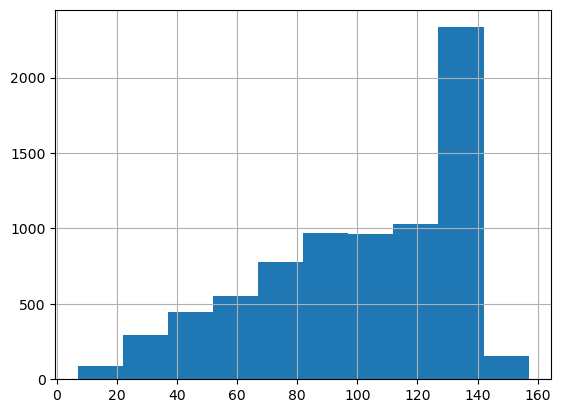

In [9]:
### model can be "case or "un cased".
### context window is 512 tokens


df['text'].str.len().hist()  ## -> 160/3 == about 53 tokens on average and then round it to about 60 tokens.

LOAD DATA WITH HUGGING FACE DATASETS LIBRARY....

In [10]:
df = df.rename(columns={'target': 'label'})

In [11]:
from datasets import Dataset
dataset = Dataset.from_pandas(df)

dataset = dataset.train_test_split(test_size = 0.2)

dataset['train'][0]

{'text': '@ego_resolution im glad. My gay can heal 1000 wounds', 'label': 0}

In [12]:
id2label = {0: 'general', 1: 'disaster'}
label2id = {'general': 0, 'disaster': 1}




TOKENIZATION SECTION.....

In [13]:
from transformers import AutoTokenizer
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_checkpoint = 'huawei-noah/TinyBERT_General_4L_312D'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


tokenizer


BertTokenizerFast(name_or_path='huawei-noah/TinyBERT_General_4L_312D', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [14]:
#tokenizer(dataset['train'][0]['text'])

def tokenizer_batch(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True, max_length= 100)
    return temp

dataset = dataset.map(tokenizer_batch, batched=True, batch_size=None)


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

BUILDING THE MODEL HERE WITH EVALUATION FUNCTIONS....

In [ ]:
#!pip install evaluate

import evaluate
import numpy as np

accuracy = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions= np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)



In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(label2id), 
                                                           label2id=label2id, id2label=id2label)


In [ ]:
args = TrainingArguments(
    output_dir="train_dir",
    overwrite_output_dir=True,
    num_train_epochs=5,
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

MODEL SAVE AND LOAD FOR INFERENCE....

In [ ]:
trainer.save_model("tinybert-disaster-tweet")

In [ ]:
from transformers import pipeline
import torch



data = ["There is a fire in the building", "I am happy today", " I am sad today",
        "I am not feeling well", "THere is a flood in the city, go to higher groung"]



device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
classifier = pipeline("text-classification", model = "tinybert-disaster-tweet", device =device)
classifier(data)

PUSH MODEL TO S3 on AWS....
(Make sure you create the bucket FIRST in AWS before you can push the model to it!)

In [ ]:
import os
import boto3


s3 = boto3.client("s3")
bucket_name = 'mlopsmorris'

def upload_directory(directoy_path, s3_prefix):
                     for root, dirs, files in os.walk(directory_path):
                        for file in files:
                            file_path = os.path.join(root, file).replace('\\', '/')
                            relpath = os.path.relpath(file_path, directory_path)
                            s3_key = os.path.join(s3_prefix, relpath).replace('\\', '/')

                            s3.upload_file(file_path, bucket_name, s3_key)

upload_directory("tinybert-disaster-tweet", "ml-models/tinybert-disaster-tweet")
                            